In [1]:
import re
from PIL import Image
from collections import defaultdict
import ast

from tqdm import tqdm
import pandas as pd
from nltk.corpus import stopwords
import spacy
import nltk
from spacy.language import Language
from spacy_langdetect import LanguageDetector
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

In [2]:
def get_lang_detector(nlp, name):
    return LanguageDetector()

OFFERS_PATH = "data/extracted_sellers_old.json"
languages = [("en")]

en_nlp = spacy.load('en_core_web_sm')

sns.set_theme()
try:
    Language.factory("language_detector", func=get_lang_detector)
except ValueError:
    pass

en_nlp.add_pipe('language_detector', last=True)
df = pd.read_json(OFFERS_PATH)
df["description"] = df["description"].str.replace("About This Gig ", "")


In [3]:
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")

en_stop = set(stopwords.words("english"))
languages = [["en"]]
def detect_language(document) -> str:
    doc = en_nlp(document)
    detect_language = doc._.language
    return(detect_language["language"])

def preprocess_html(document):
    # Remove all the special characters
    document = re.sub(r"\W", " ", str(document))

    # remove all single characters
    document = re.sub(r"\s+[a-zA-Z]\s+", " ", document)

    # Remove single characters from the start
    document = re.sub(r"\^[a-zA-Z]\s+", " ", document)

    # Substituting multiple spaces with single space
    document = re.sub(r"\s+", " ", document, flags=re.I)

    # Removing prefixed 'b'
    document = re.sub(r"^b\s+", "", document)

    return document


def preprocess_text(document, ret_lang: bool = True):
    document = preprocess_html(document)

    doc = en_nlp(document)
    tokens = [word.lemma_ for word in doc]
    tokens = [word for word in tokens if word not in en_stop]

    if ret_lang:
        lang = detect_language(document)
        return tokens, lang
    return tokens


[nltk_data] Downloading package punkt to /home/patryk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/patryk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/patryk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# tqdm.pandas()
# df["description_lem"], df["lang"] = zip(*df["description"].progress_apply(lambda x: preprocess_text(x)))
# df["skills_lem"] = df["skills"].progress_apply(lambda x: [preprocess_text(y, False) for y in x] if x else [])
# df["education_lem"] = df["education"].progress_apply(lambda x: [preprocess_text(y, False) for y in x] if x else [])
# df["languages_lem"]  = df["languages"].progress_apply(lambda x: [preprocess_text(y, False) for y in x] if x else [])


# df.to_csv("analyzis/sellers_extracted_lem.csv")

In [5]:
# df.to_csv("out/extracted_sellers_lem.csv")

In [6]:
df = pd.read_csv("analyzis/sellers_extracted_lem.csv")
df["description_lem"] = df["description_lem"].apply(lambda x: ast.literal_eval(x))
df["skills_lem"] = df["skills_lem"].apply(lambda x: ast.literal_eval(x))
df["skills"] = df["skills"].apply(lambda x: ast.literal_eval(x) if not isinstance(x, float) else [])
df["languages"] = df["languages"].apply(lambda x: ast.literal_eval(x) if not isinstance(x, float) else [])
df["education_lem"] = df["education_lem"].apply(lambda x: ast.literal_eval(x))
df["languages_lem"] = df["languages_lem"].apply(lambda x: ast.literal_eval(x))

# Ile sprzedawców z jakiego języka?

In [7]:
print(df.groupby(by="lang")["name"].count().sort_values(ascending=False).to_latex())

\begin{tabular}{lr}
\toprule
{} &   name \\
lang    &        \\
\midrule
en      &  55273 \\
no      &    252 \\
es      &    172 \\
it      &    110 \\
de      &     82 \\
fr      &     76 \\
UNKNOWN &     18 \\
pt      &     14 \\
nl      &     13 \\
da      &     11 \\
tr      &      8 \\
ru      &      7 \\
ca      &      6 \\
id      &      6 \\
tl      &      4 \\
cy      &      4 \\
vi      &      4 \\
af      &      3 \\
he      &      3 \\
so      &      3 \\
ro      &      2 \\
sk      &      2 \\
fi      &      2 \\
et      &      2 \\
pl      &      2 \\
ar      &      1 \\
lt      &      1 \\
sl      &      1 \\
sw      &      1 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1380125/4040834820.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.groupby(by="lang")["name"].count().sort_values(ascending=False).to_latex())


In [8]:
df = df[df["lang"] == "en"]

In [9]:
df_cat = pd.DataFrame(columns=["type", "length"])

# Rozkład długości tekstów

/tmp/ipykernel_1380125/3882206452.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cat = df_cat.append([{"type": "description", "length": elem} for (_, elem) in enumerate(tokens_desc)], ignore_index=True)


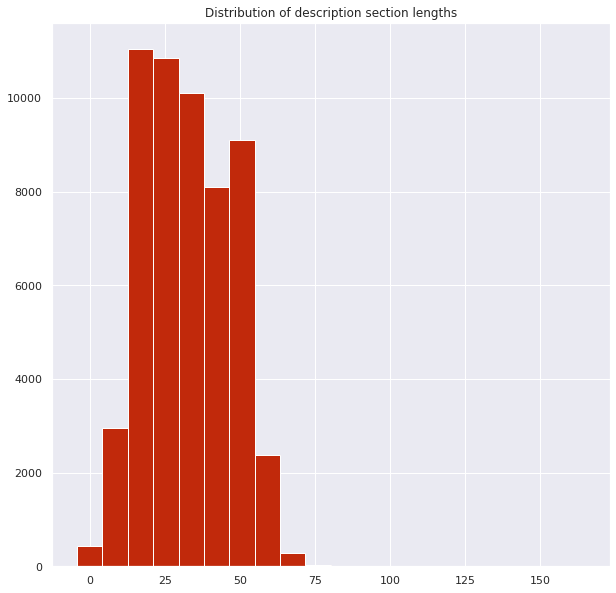

In [10]:
tokens_desc = [len(row) for row in df["description_lem"]]
df_cat = df_cat.append([{"type": "description", "length": elem} for (_, elem) in enumerate(tokens_desc)], ignore_index=True)
df["description_len"] = tokens_desc
plt.figure(figsize=(10, 10))
plt.title(f"Distribution of description section lengths")
_ = plt.hist(tokens_desc, bins=20, color="#c1290b", align='left')

/tmp/ipykernel_1380125/2824439581.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cat = df_cat.append([{"type": "skills", "length": elem} for (_, elem) in enumerate(tokens_skills)], ignore_index=True)


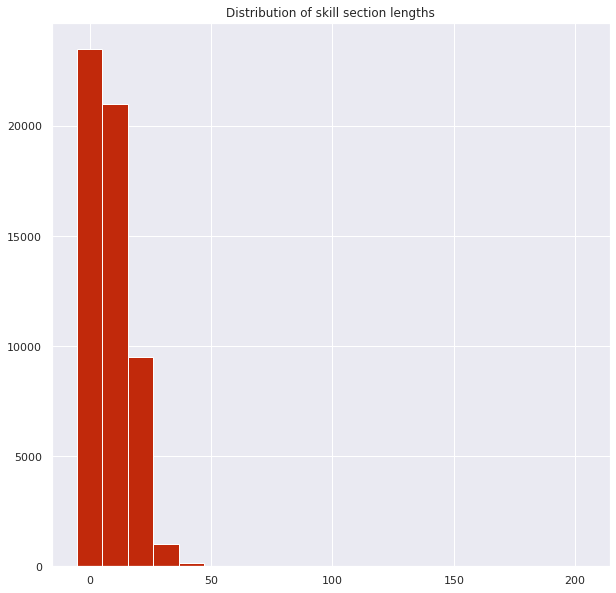

In [11]:
tokens_skills = [[word for item in row for word in item] for row in df["skills_lem"]]
df["skills_lem_merged"] = tokens_skills
tokens_skills = [len(item) for item in tokens_skills]
df_cat = df_cat.append([{"type": "skills", "length": elem} for (_, elem) in enumerate(tokens_skills)], ignore_index=True)
plt.figure(figsize=(10, 10))
plt.title(f"Distribution of skill section lengths")
_ = plt.hist(tokens_skills, bins=20, color="#c1290b", align="left")

In [12]:
df["skills_lem_merged"] 

0        [typewrite, data, entry, Microsoft, Word, type...
1                     [Graphic, design, Microsoft, Office]
2                                           [Logo, design]
3        [3d, modelling, Spark, AR, Studio, 3d, renderi...
4        [paper, craft, datum, scrape, data, entry, MS,...
                               ...                        
56078      [Digital, marketing, social, medium, marketing]
56079    [online, teaching, content, write, cv, writing...
56080    [Autodesk, 3ds, Max, Logo, design, Graphic, de...
56081    [crowdfunde, crowdfunde, campaign, creation, s...
56082    [Logo, design, branding, paint, vector, illust...
Name: skills_lem_merged, Length: 55273, dtype: object

/tmp/ipykernel_1380125/1599459594.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cat = df_cat.append([{"type": "education", "length": elem} for (_, elem) in enumerate(tokens_education)], ignore_index=True)


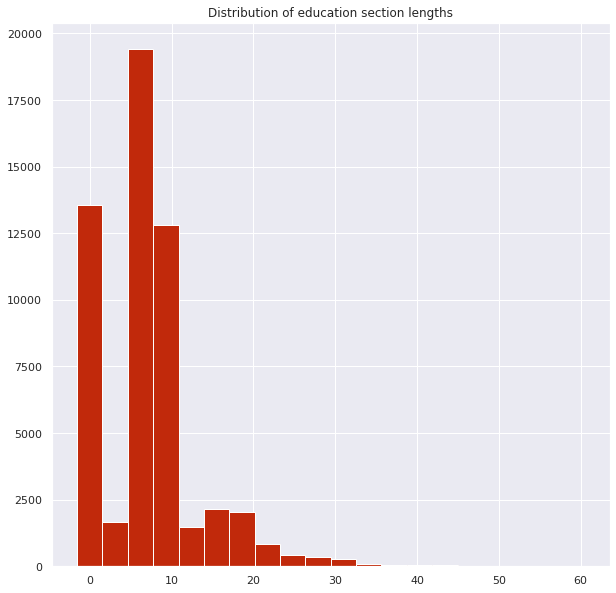

In [13]:
tokens_education = [[word for item in row for word in item] for row in df["education_lem"]]
df["education_lem_merged"] = tokens_education
tokens_education = [len(item) for item in tokens_education]
df_cat = df_cat.append([{"type": "education", "length": elem} for (_, elem) in enumerate(tokens_education)], ignore_index=True)
plt.figure(figsize=(10, 10))
plt.title(f"Distribution of education section lengths")
_ = plt.hist(tokens_education, bins=20, color="#c1290b", align="left")

/tmp/ipykernel_1380125/1826140946.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cat = df_cat.append([{"type": "languages", "length": elem} for (_, elem) in enumerate(tokens_language)], ignore_index=True)


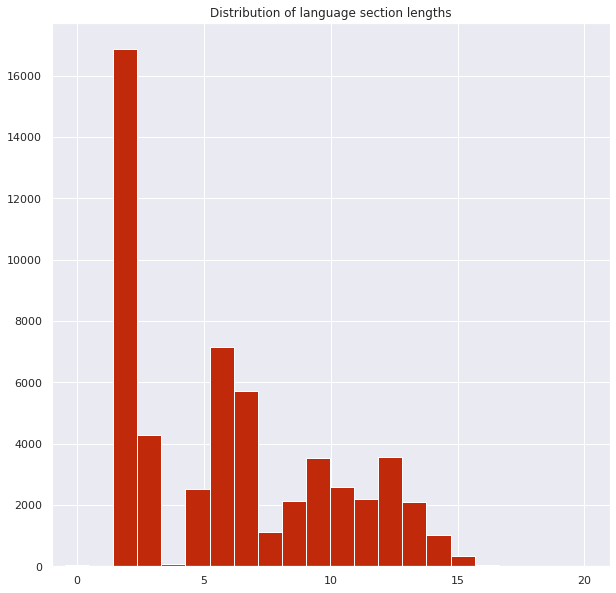

In [14]:
tokens_language = [[word for item in row for word in item] for row in df["languages_lem"]]
df["language_lem_merged"] = tokens_language
tokens_language = [len(item) for item in tokens_language]
df_cat = df_cat.append([{"type": "languages", "length": elem} for (_, elem) in enumerate(tokens_language)], ignore_index=True)
plt.figure(figsize=(10, 10))
plt.title(f"Distribution of language section lengths")
plt.xlim([-1, 21])
plt.xticks(np.arange(0, 21, 5))
_ = plt.hist(tokens_language, bins=20, color="#c1290b", align="left")

/tmp/ipykernel_1380125/31004211.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cat = df_cat.append([{"type": "total", "length": elem} for (_, elem) in enumerate(tokens_total)], ignore_index=True)


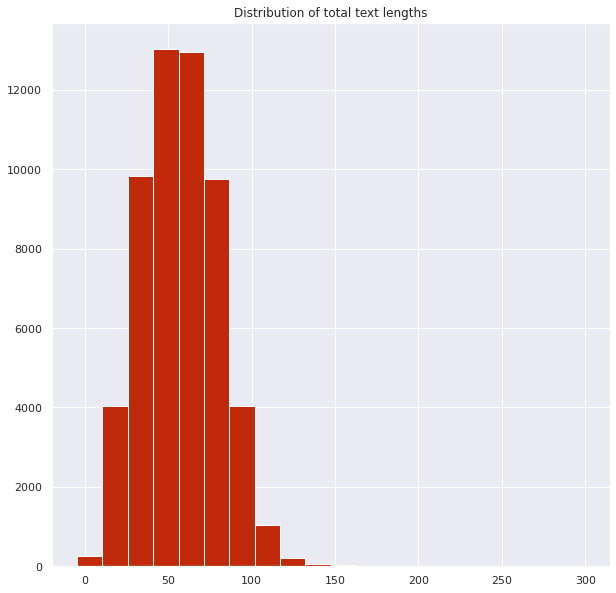

In [15]:
tokens_total = np.array(tokens_desc) + np.array(tokens_skills) + np.array(tokens_education) + np.array(tokens_language)
df_cat = df_cat.append([{"type": "total", "length": elem} for (_, elem) in enumerate(tokens_total)], ignore_index=True)
plt.figure(figsize=(10, 10))
df["total_len"] = tokens_total
plt.title(f"Distribution of total text lengths")
# plt.xlim([-1, 21])
# plt.xticks(np.arange(0, 21, 5))
_ = plt.hist(tokens_total, bins=20, color="#c1290b", align="left")

<Figure size 1440x1440 with 0 Axes>

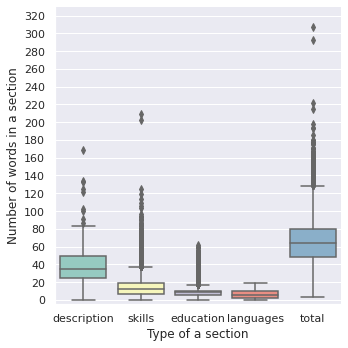

In [16]:
# sns.set_theme()

plt.figure(figsize=(20, 20))

sns.catplot(x='type', y='length', data=df_cat, kind='box', palette=sns.color_palette("Set3"))
plt.xlabel("Type of a section")
plt.ylabel("Number of words in a section")
plt.ylim([-5, 330])
_ = plt.yticks(np.arange(0, 330, step=20))
plt.savefig("analyzis/len_dist.png", dpi=300)

# N-GRAMS

In [17]:
df["total_lem"] = df["description_lem"] + df["skills_lem_merged"] + df["education_lem_merged"] + df["language_lem_merged"]
df["total_lem"] = df["total_lem"].apply(lambda x: [item.encode("ascii", "ignore").decode().replace("() ", "") for item in x])

<Figure size 432x288 with 0 Axes>

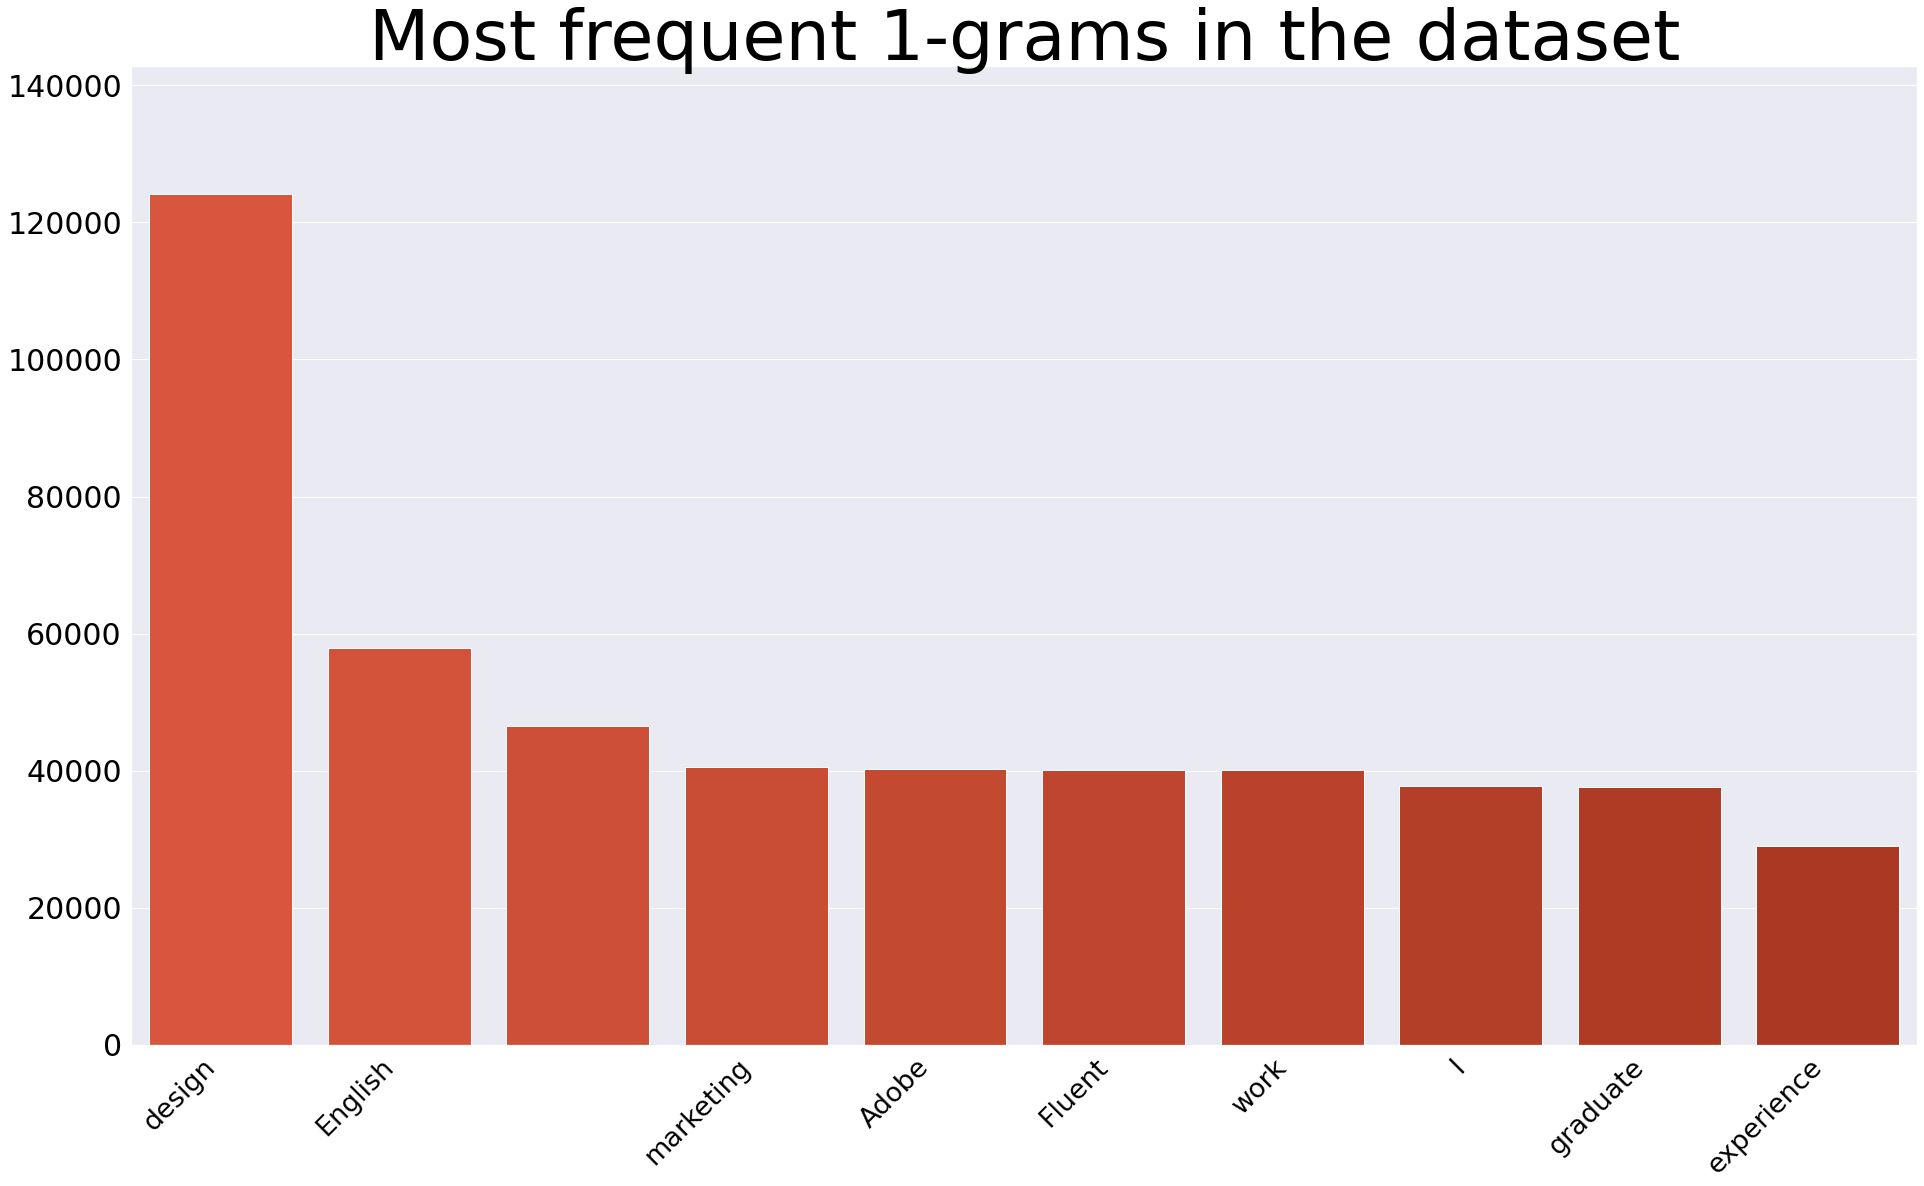

<Figure size 432x288 with 0 Axes>

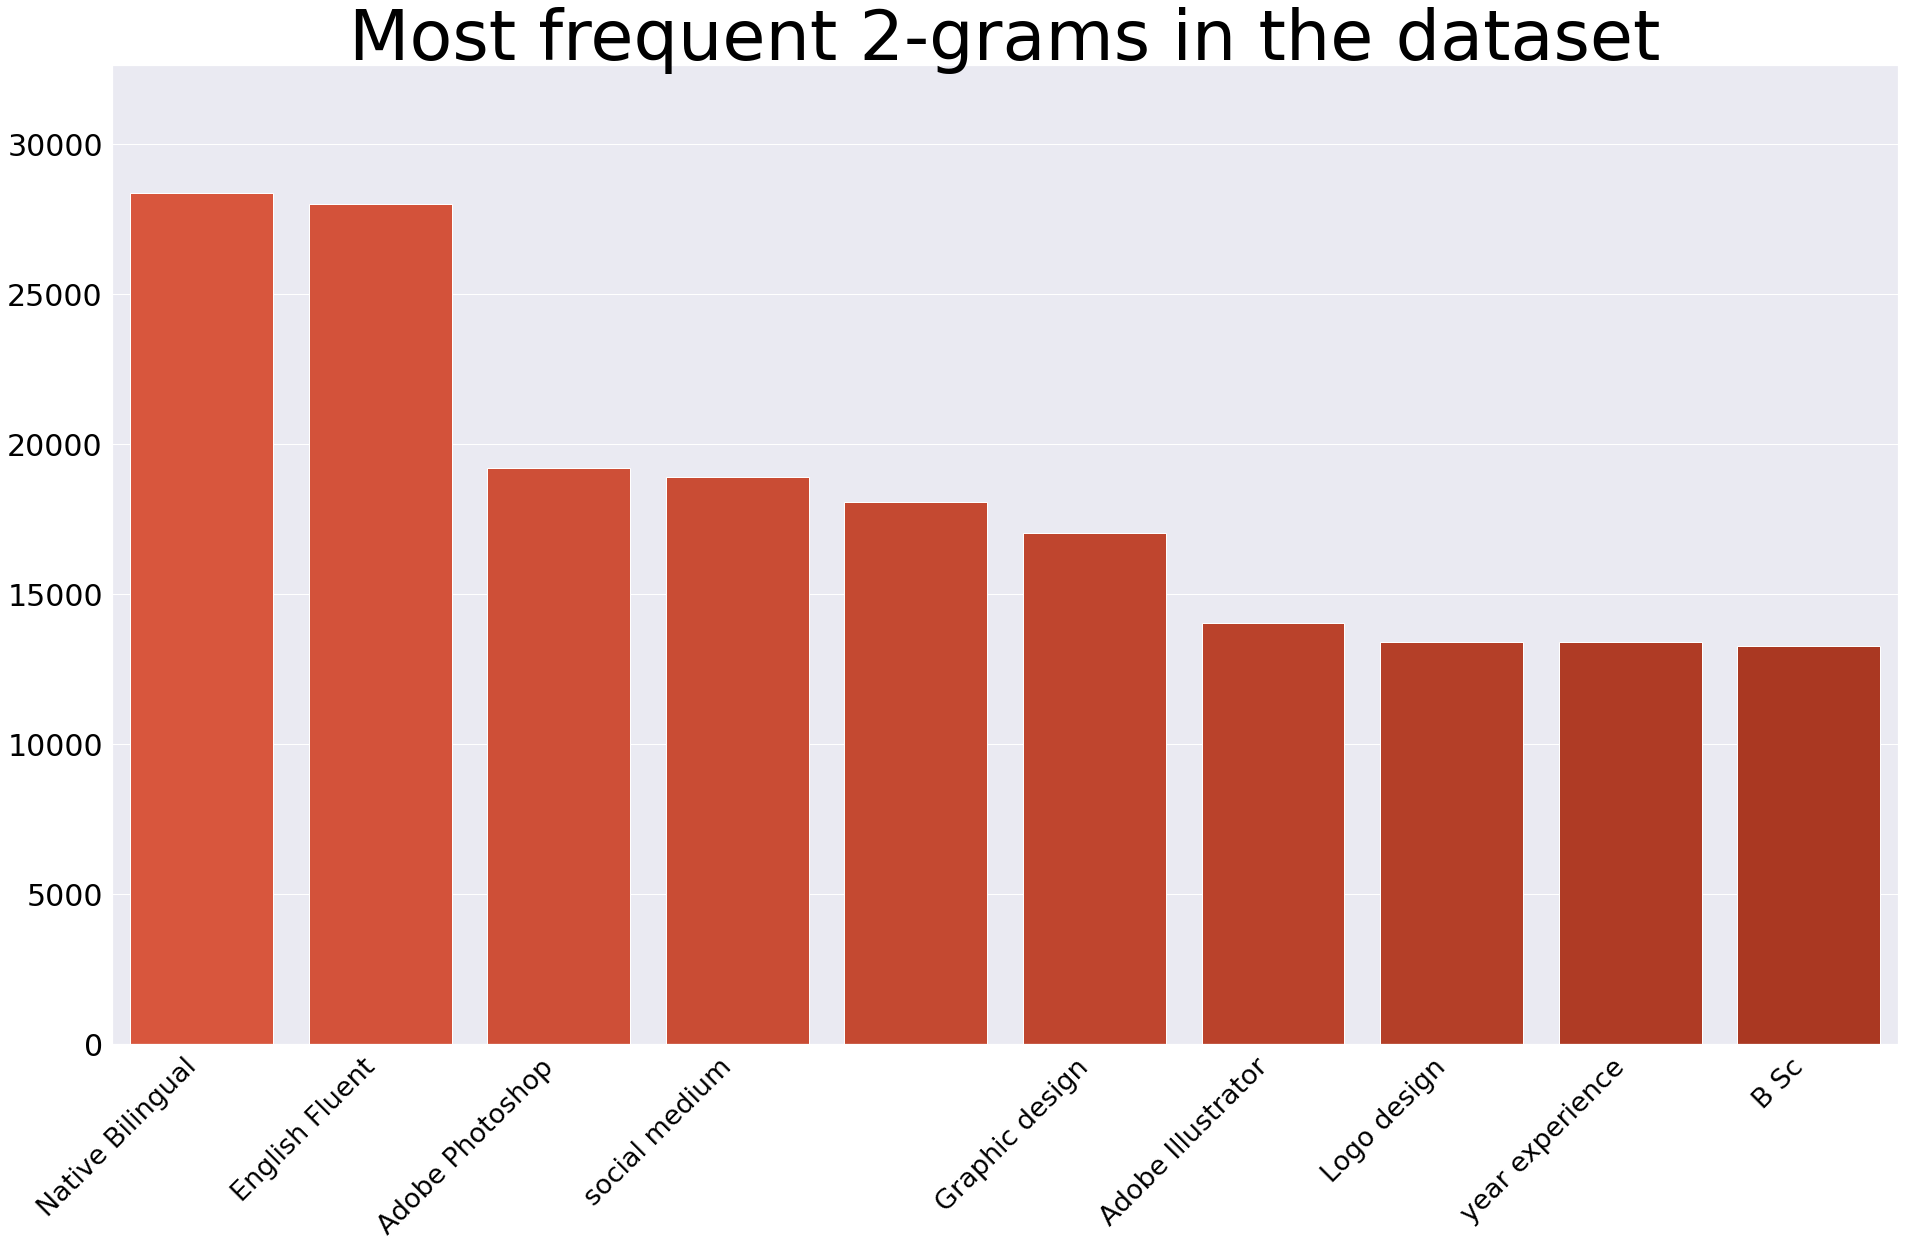

<Figure size 432x288 with 0 Axes>

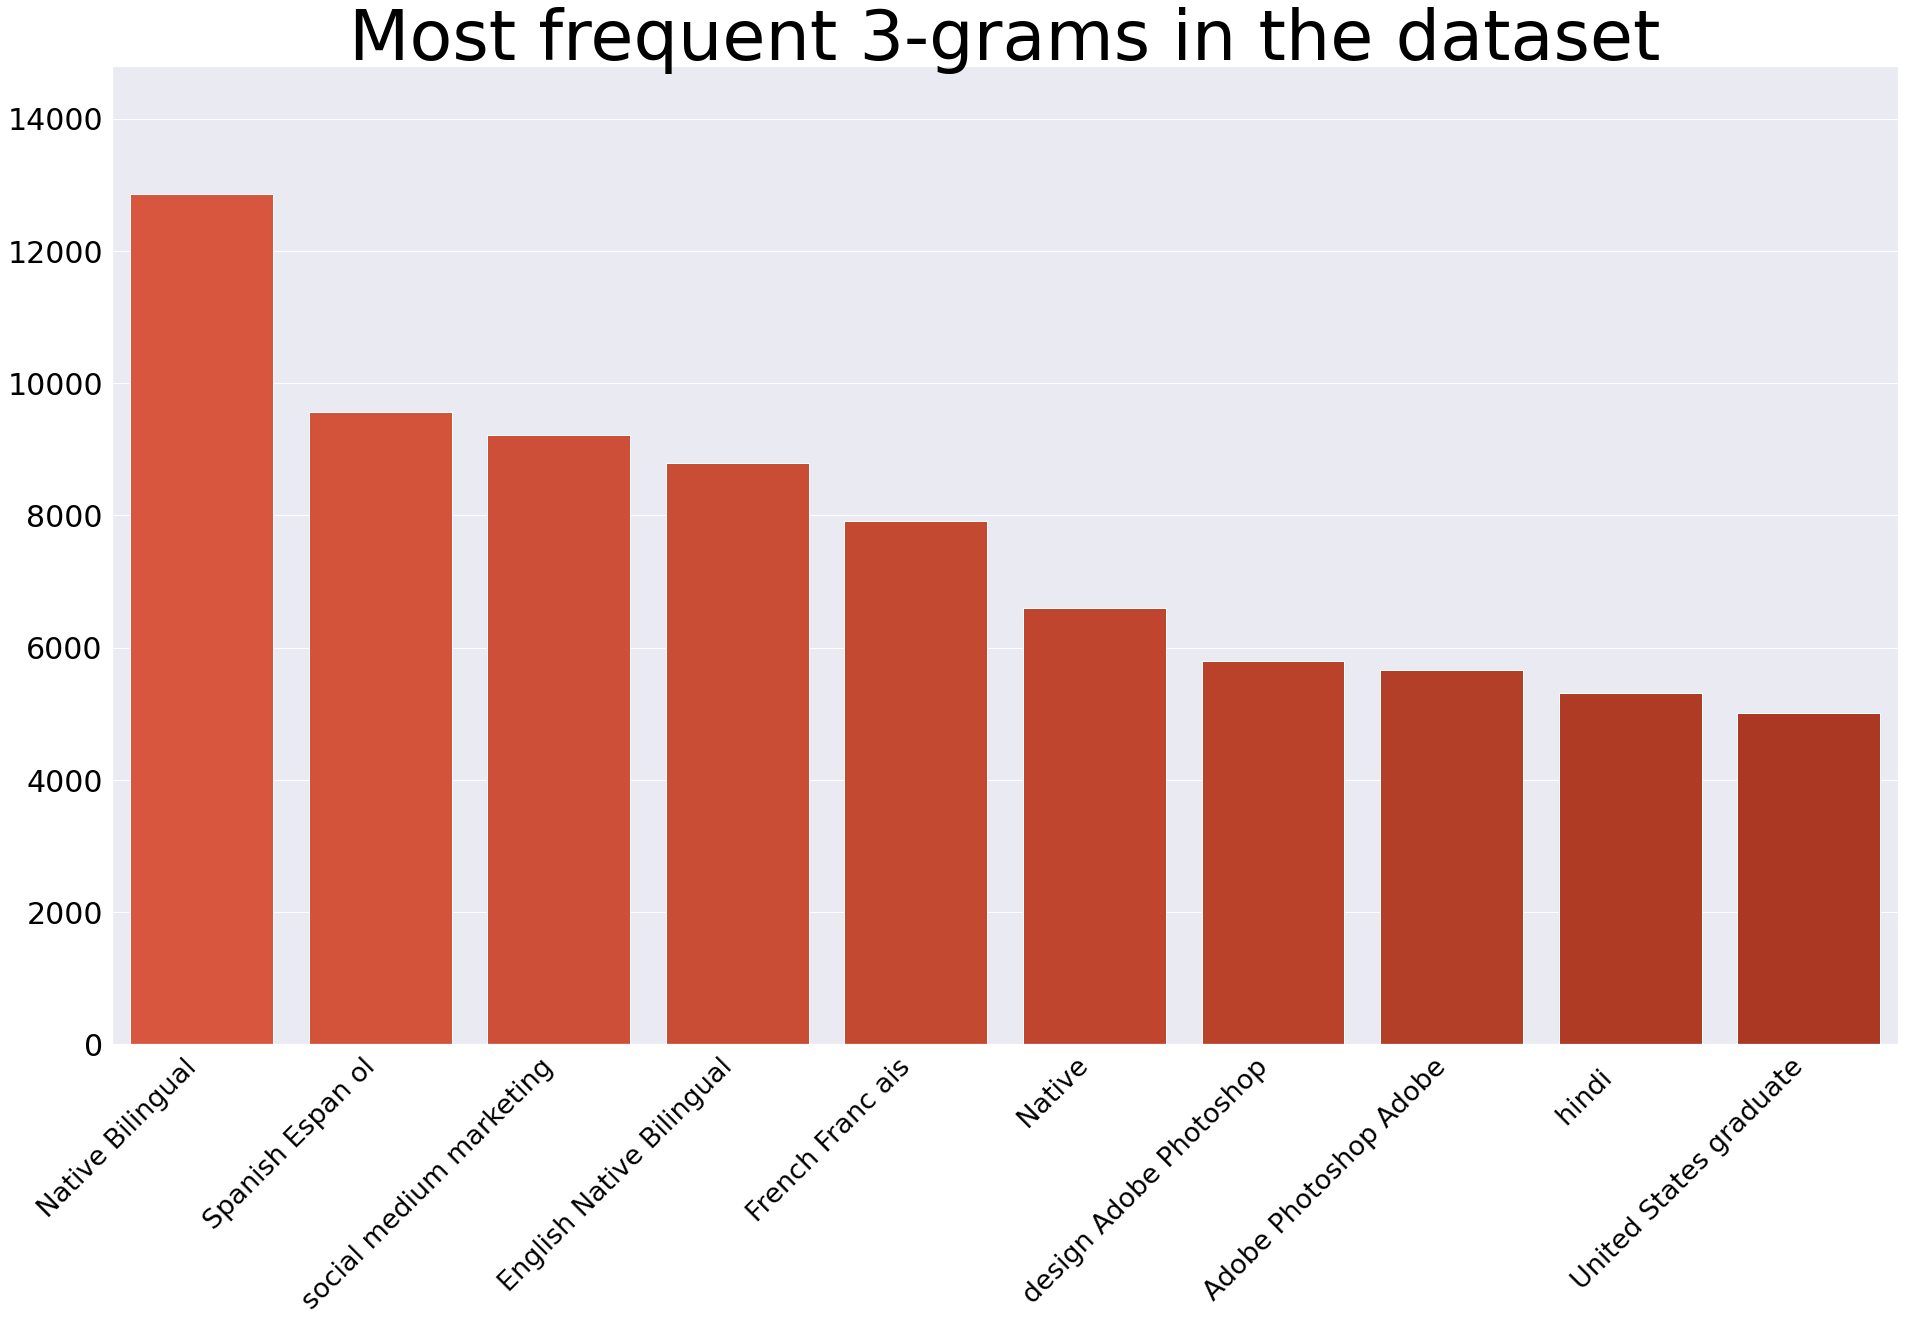

In [18]:
n_grams = [1, 2, 3]

for n_gram in n_grams:
    tokens = [word for row in df["total_lem"] for word in row]
    grams_2 = nltk.ngrams(tokens, n_gram)
    freq_2 = nltk.FreqDist(grams_2)
    data = [{" ".join(gram): freq} for (gram, freq) in freq_2.items()]
    data.sort(key=lambda x: -list(x.values())[0])

    keys = np.array([list(item.keys())[0] for item in data])[:10]
    values = np.array([list(item.values())[0] for item in data])[:10]

    order = np.argsort(values)[::]

    for i in [18]:
        plt.figure()
        sns.set_theme()
        # COLOR = 'white'
        COLOR = 'black'
        mpl.rcParams['text.color'] = COLOR
        mpl.rcParams['axes.labelcolor'] = COLOR
        mpl.rcParams['xtick.color'] = COLOR
        mpl.rcParams['ytick.color'] = COLOR
        pal_red = sns.color_palette('blend:#f24423,#c1290b', len(keys))
        fig = plt.figure(figsize=(32, i))
        graph = sns.barplot(x = keys, y = values, palette= np.array(pal_red[::-1])[order])
        graph.set_title(f"Most frequent {n_gram}-grams in the dataset", fontsize=70)
        ax = plt.gca()
        plt.ylim(0, max(values) + 0.15*max(values)) 
        # ax.bar_label(ax.containers[0], labels =["{:.2f}".format(val) for val in values], fontsize=20)
        ax.tick_params(axis='y', which='major', labelsize=30)
        graph.set_xticklabels(graph.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=27)
        # plt.savefig(f"words_32_{i}.png", transparent=True, dpi=300)
        plt.show()


# Wordclouds

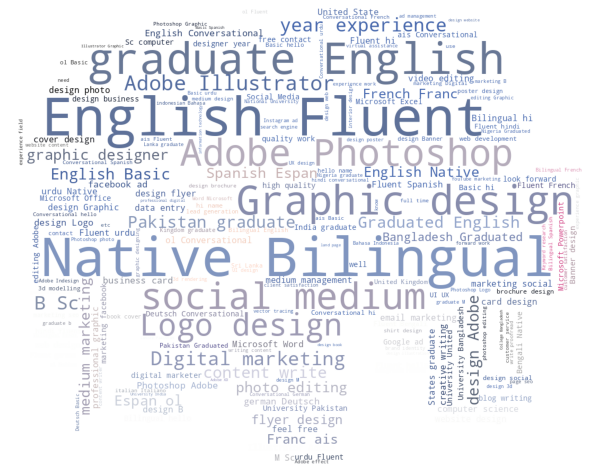

In [20]:
background_image = np.array(Image.open('analyzis/img/osiolek.jpg'))
img_colors = ImageColorGenerator(background_image)

wordcloud = WordCloud(
    width=3000,
    height=2400,
    background_color="white",
    mask=background_image,
    color_func=img_colors
    # color_func = grey_color_func
).generate(" ".join([" ".join(row) for row in df["total_lem"]]))

plt.figure(figsize=(8, 8), facecolor=None)
# plt.title(f"Wordcloud for languages {lang}")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig("analyzis/wordcloud.png", dpi=300)

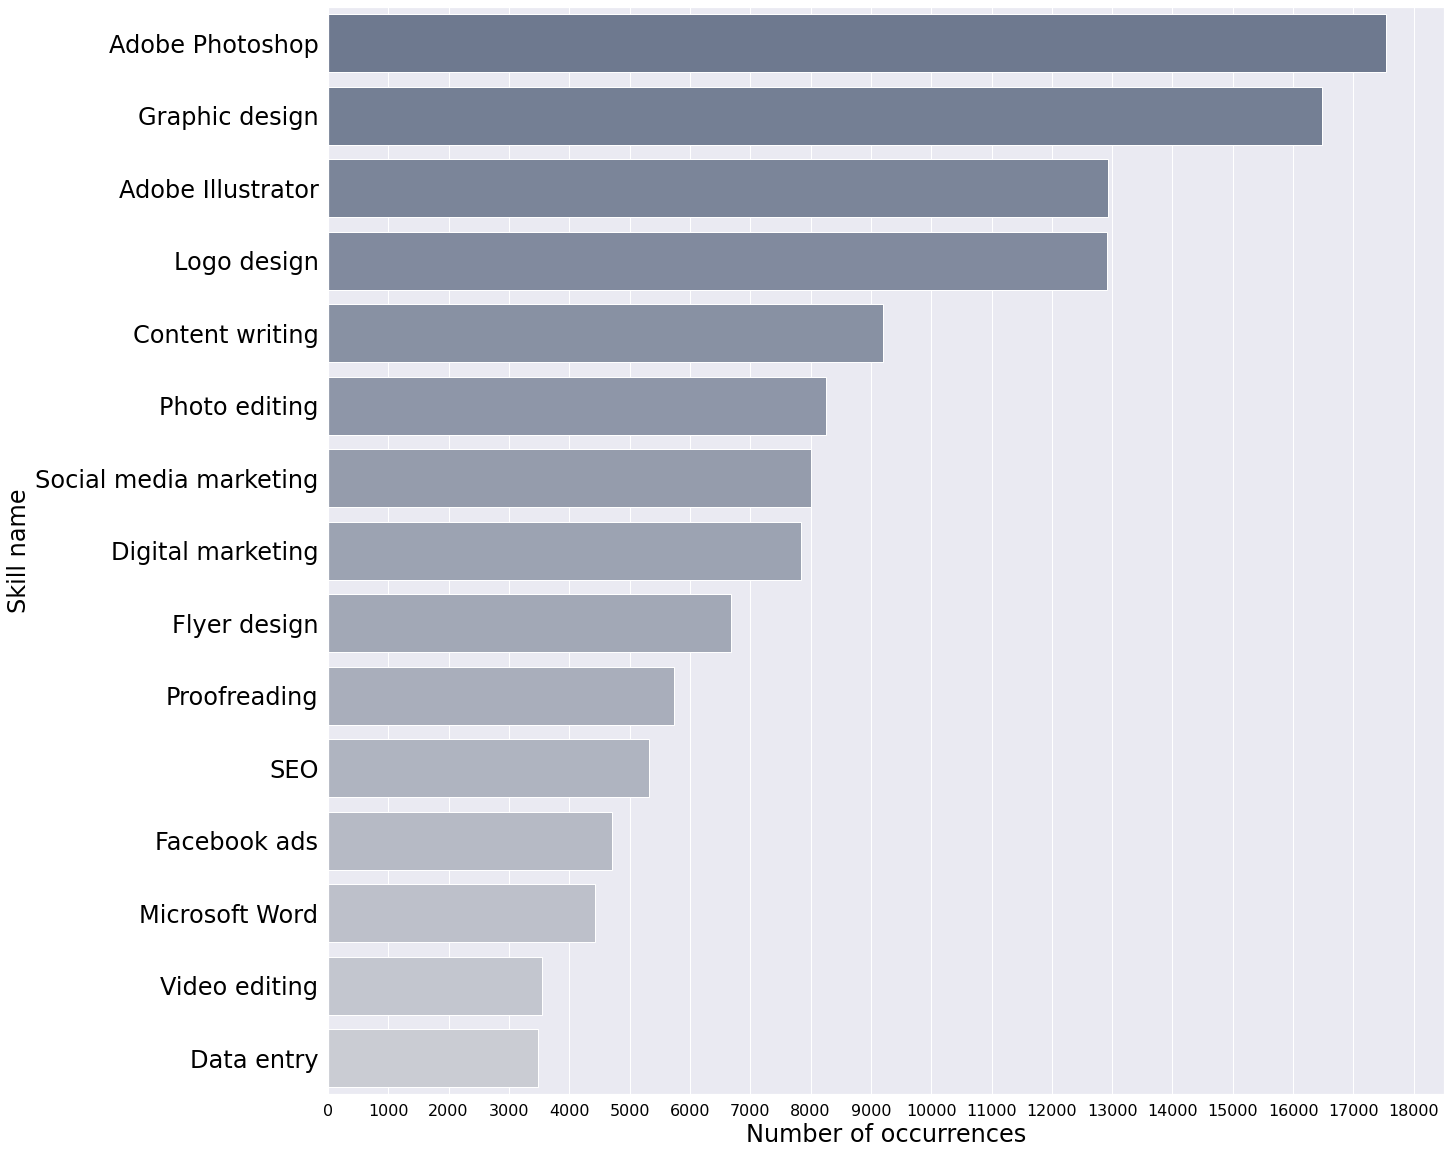

In [73]:
skills_dict: dict = defaultdict(lambda: 0)
for lang in languages:
    for skills in df["skills"]:
        for skill in skills:
            skills_dict[skill.encode("ascii", "ignore").decode().replace("() ", "")] += 1


    skills = {k: v for k, v in sorted(skills_dict.items(), key=lambda item: -item[1])}
 
    keys, values = zip(*sorted(skills_dict.items(), key=lambda item: -item[1])[:15])
    keys = np.array(keys)
    values = np.array(values)

    pal_red = sns.color_palette('blend:#687795,#c8cbd5', len(values))
    fig = plt.figure(figsize=(20, 20))
    graph = sns.barplot(y = keys, x = values, palette=pal_red)
    # graph.set_title(f"Most frequent skills", fontsize=70)
    ax = plt.gca()
    # plt.ylim(0, max(values) + 0.15*max(values)) 
    # ax.bar_label(ax.containers[0], labels =["{:.2f}".format(val) for val in values], fontsize=20)
    # ax.tick_params(axis='y', which='major', labelsize=30)
    graph.set_yticklabels(graph.get_yticklabels(), horizontalalignment='right', fontsize=24)
    plt.xticks(np.arange(0, 18001, 1000), fontsize=16)
    plt.xlabel("Number of occurrences", fontsize=24)
    plt.ylabel("Skill name", fontsize=24)
    plt.xlim([0, 18500])
    plt.savefig("analyzis/skills.png", dpi=300, bbox_inches='tight')

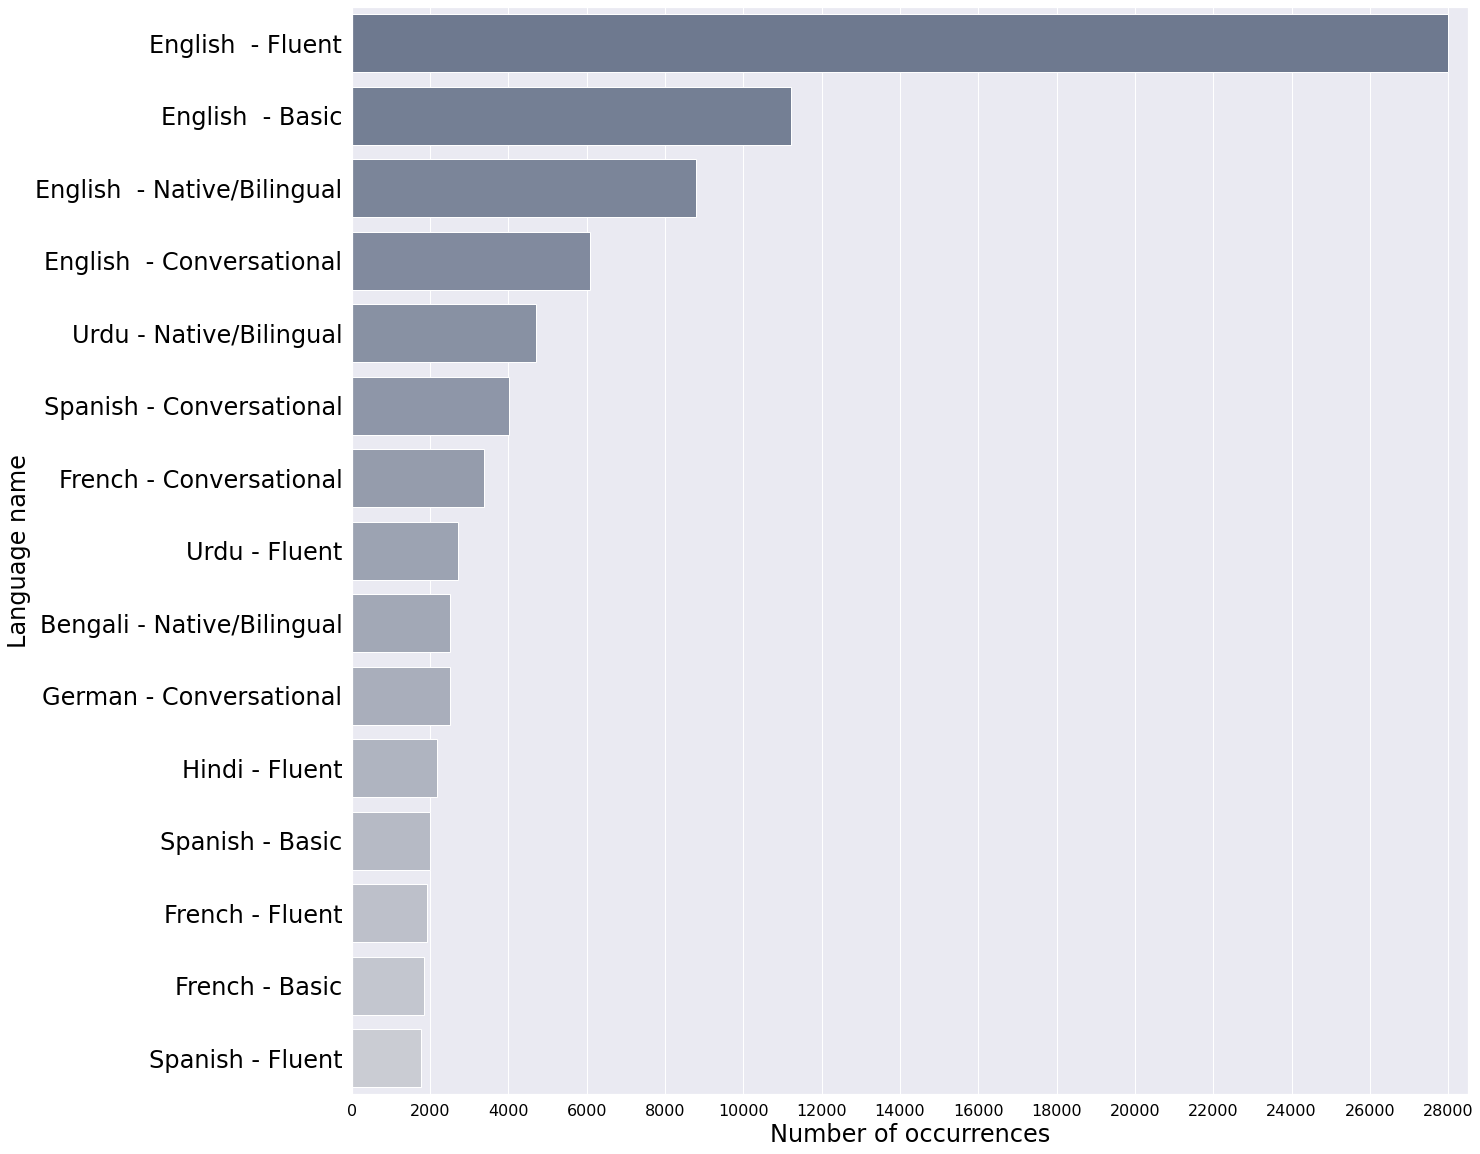

In [74]:
lang_dict: dict = defaultdict(lambda: 0)
for lang in languages:
    for skills in df["languages"]:
        for skill in skills:
            lang_dict[re.sub(r"\(\w*\) ", "", skill.encode("ascii", "ignore").decode().replace("() ", ""))] += 1


    skills = {k: v for k, v in sorted(lang_dict.items(), key=lambda item: -item[1])}
 
    keys, values = zip(*sorted(lang_dict.items(), key=lambda item: -item[1])[:15])
    keys = np.array(keys)
    values = np.array(values)

    pal_red = sns.color_palette('blend:#687795,#c8cbd5', len(values))
    fig = plt.figure(figsize=(20, 20))
    graph = sns.barplot(y = keys, x = values, palette=pal_red)
    
    # graph.set_title(f"Most frequent skills", fontsize=70)
    ax = plt.gca()
    # plt.ylim(0, max(values) + 0.15*max(values)) 
    # ax.bar_label(ax.containers[0], labels =["{:.2f}".format(val) for val in values], fontsize=20)
    # ax.tick_params(axis='y', which='major', labelsize=30)
    # graph.set_xticklabels(graph.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=27)
    
    graph.set_yticklabels(graph.get_yticklabels(), horizontalalignment='right', fontsize=24)
    plt.xticks(np.arange(0, 28001, 2000), fontsize=16)
    plt.xlabel("Number of occurrences", fontsize=24)
    plt.ylabel("Language name", fontsize=24)
    plt.xlim([0, 28500])
    plt.savefig("analyzis/languages.png", dpi=300, bbox_inches='tight')

In [78]:
print(len(df))
df.dropna(
            subset=[
                "skills",
                "education",
                "languages",
            ]
        )

55273


,Unnamed: 0,name,description,languages,skills,education,description_lem,lang,skills_lem,education_lem,languages_lem,description_len,skills_lem_merged,education_lem_merged,language_lem_merged,total_len,total_lem
0,0,oyuchi,I am a passionate content writer. I have writt...,[English - Basic],"[Typewriting, Data entry, Microsoft Word, Typi...","['B.Sc. - nursing Nairobi University, Kenya, G...","[I, passionate, content, writer, write, resear...",en,"[[typewrite], [data, entry], [Microsoft, Word]...","[[B, Sc, nursing, Nairobi, University, Kenya, ...","[[English, Basic]]",36,"[typewrite, data, entry, Microsoft, Word, type...","[B, Sc, nursing, Nairobi, University, Kenya, g...","[English, Basic]",55,"[I, passionate, content, writer, write, resear..."
1,1,anas4300,I am a professional graphic designer. I have 5...,[English - Conversational],"[Graphic design, Microsoft Office]",['B.Sc. - computer science government degree c...,"[I, professional, graphic, designer, 5, year, ...",en,"[[Graphic, design], [Microsoft, Office]]","[[B, Sc, computer, science, government, degree...","[[English, Conversational]]",39,"[Graphic, design, Microsoft, Office]","[B, Sc, computer, science, government, degree,...","[English, Conversational]",57,"[I, professional, graphic, designer, 5, year, ..."
3,3,riccardo_urban,I am a geek passionate about innovation and bu...,"[English - Fluent, Italian (Italiano) - Nativ...","[3D modelling, Spark AR Studio, 3D rendering, ...",['Other - computerscience engineering Univesit...,"[I, geek, passionate, innovation, business, wo...",en,"[[3d, modelling], [Spark, AR, Studio], [3d, re...","[[computerscience, engineer, Univesita, Roma, ...","[[English, Fluent], [italian, Italiano, Native...",15,"[3d, modelling, Spark, AR, Studio, 3d, renderi...","[computerscience, engineer, Univesita, Roma, T...","[English, Fluent, italian, Italiano, Native, B...",60,"[I, geek, passionate, innovation, business, wo..."
4,4,gm_creations,"Hello everyone,\nI am an Artist and Illustrato...","[English - Basic, Hindi (हिंदी) - Fluent]","[Paper crafting, Data scraping, Data entry MS ...","['M.Sc. - mathematics Ravenshaw University, In...","[hello, everyone, Artist, Illustrator, Digital...",en,"[[paper, craft], [datum, scrape], [data, entry...","[[M, Sc, mathematic, Ravenshaw, University, In...","[[English, Basic], [hindi, ह, द, fluent]]",26,"[paper, craft, datum, scrape, data, entry, MS,...","[M, Sc, mathematic, Ravenshaw, University, Ind...","[English, Basic, hindi, ह, द, fluent]",58,"[hello, everyone, Artist, Illustrator, Digital..."
5,5,ricardocontr378,Marketing and strategy expert with more than 5...,"[English - Conversational, Spanish (Español)...","[Digital marketing, Copywriting, Social media ...",['B.Sc. - marketingmanagement University Cente...,"[marketing, strategy, expert, 5, year, experie...",en,"[[Digital, marketing], [copywrite], [social, m...","[[B, Sc, marketingmanagement, University, Cent...","[[English, Conversational], [Spanish, Espan, o...",17,"[Digital, marketing, copywrite, social, medium...","[B, Sc, marketingmanagement, University, Cente...","[English, Conversational, Spanish, Espan, ol, ...",49,"[marketing, strategy, expert, 5, year, experie..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56073,56073,nahia_gx,"Hey, I am Nahia Islam. I'm a Professional Grap...","[English - Fluent, German (Deutsch) - Convers...","[Adobe Photoshop, Logo design, Flyer design, G...","[""Other - bba hon's management at national uni...","[hey, Nahia, Islam, Professional, Graphic, UI,...",en,"[[Adobe, Photoshop], [Logo, design], [flyer, d...","[[bba, hon, management, national, university, ...","[[English, Fluent], [German, Deutsch, Conversa...",63,"[Adobe, Photoshop, Logo, design, flyer, design...","[bba, hon, management, national, university, b...","[English, Fluent, German, Deutsch, Conversatio...",107,"[hey, Nahia, Islam, Professional, Graphic, UI,..."
56074,56074,designermanrk,Good Day!\nMy name is MD. RUKUNUZZAMAN. I

In [82]:
df["lang"]

0        en
1        en
2        en
3        en
4        en
         ..
56078    en
56079    en
56080    en
56081    en
56082    en
Name: lang, Length: 55273, dtype: object